# EXTRACTION DE KEYWORDS POUR L'AMOUR ATYPIQUE
### Corpus CAMille - Presse belge francophone (1831-1993)


## Imports

In [74]:
import os
import re 
import yake
import pandas as pd
from tqdm import tqdm
import spacy
from collections import defaultdict


In [ ]:
# Initialisation du modèle spaCy et YAKE
nlp = spacy.load("fr_core_news_lg", disable=["ner", "parser"])
kw_extractor = yake.KeywordExtractor(
    lan="fr", n=3, dedupLim=0.9, dedupFunc='seqm',
    windowsSize=2, top=100, features=None
)

In [61]:
# chein vers le ficher
data_path = "../../data/txt_tp4"
files = sorted([f for f in os.listdir(data_path) if f.endswith('.txt')])
print(f" {len(files)} fichiers trouvés (ex: {files[:3]})")

 512 fichiers trouvés (ex: ['KB_JB1051_1924-08-20_01-00004.txt', 'KB_JB1051_1928-05-11_01-00004.txt', 'KB_JB1051_1928-05-18_01-00004.txt'])


In [62]:
def nettoyer_texte(text):
    """Nettoie le texte (OCR errors, ponctuation)"""
    text = re.sub(r'[^\w\s\'\-]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def filtrer_keywords(keywords):
    """Filtre les keywords pour l'amour atypique"""
    mots_exclus = {"gay", "bruxelles", "rue", "maison", "prix", "notaire", "trans", "transport"}
    mots_cibles = {"amour", "mariage", "couple", "homosexuel", "secret", "scandale", "clandestin"}

    keywords_filtres = []
    for kw, score in keywords:
        kw_lower = kw.lower()
        if any(exclu in kw_lower for exclu in mots_exclus):
            continue
        if any(cible in kw_lower for cible in mots_cibles):
            keywords_filtres.append((kw, score))
            continue
        doc = nlp(kw)
        if any(ent.label_ in ("PER", "ORG", "LOC", "GPE") for ent in doc.ents):
            continue
        keywords_filtres.append((kw, score * 1.2))

    return sorted(keywords_filtres, key=lambda x: x[1])

In [64]:
# traitement 
results = []
for f in tqdm(files, desc="Traitement des fichiers"):
    try:
        # 1. Lecture et nettoyage
        with open(os.path.join(data_path, f), 'r', encoding='utf-8') as file:
            text = nettoyer_texte(file.read())

        # 2. Extraction et filtrage
        keywords = kw_extractor.extract_keywords(text)
        keywords_filtres = filtrer_keywords(keywords)

        # 3. Extraction des bigrammes et date
        bigrams = [kw for kw, _ in keywords_filtres if len(kw.split()) == 2]
        date_match = re.search(r'(\d{4}-\d{2}-\d{2})', f)
        date = date_match.group(1) if date_match else None

        # 4. Stockage (même sans bigrammes, si keywords pertinents)
        if keywords_filtres:  # ← CONDITION ASSOUPLIE
            results.append({
                "fichier": f,
                "date": date,
                "bigrams": ", ".join(bigrams[:5]) if bigrams else "Aucun",
                "top_keywords": keywords_filtres[:5]
            })

    except Exception as e:
        print(f"Erreur avec {f}: {str(e)}")

Traitement des fichiers: 100%|██████████| 512/512 [08:19<00:00,  1.02it/s]


In [65]:
# Afficher les résultats
print("\n--- Top 10 fichiers avec keywords pertinents ---")
for i, res in enumerate(results[:10], 1):
    print(f"\n{i}. {res['fichier']} (Date: {res['date']})")
    print("   Top bigrammes:", res['bigrams'])
    print("   Top keywords:",
          [f"{kw} (score: {score:.4f})" for kw, score in res['top_keywords']])


--- Top 10 fichiers avec keywords pertinents ---

1. KB_JB1051_1924-08-20_01-00004.txt (Date: 1924-08-20)
   Top bigrammes: Aucun
   Top keywords: ['ASSEMBLEE PLENIERE Dimanche (score: 0.0000)', 'che gli opérai (score: 0.0000)', 'Soignies Mme Demeuldre (score: 0.0000)', 'Mme Jean Matagne (score: 0.0000)', 'BORINAGE ASSEMBLEE PLENIERE (score: 0.0000)']

2. KB_JB1051_1928-05-11_01-00004.txt (Date: 1928-05-11)
   Top bigrammes: Aucun
   Top keywords: ["Gros plan d'un (score: 0.0000)", "d'un personnage d'un (score: 0.0000)", 'gros plan Exemple (score: 0.0000)', "films artistiques Jusqu'en (score: 0.0000)", "plan d'un grand (score: 0.0000)"]

3. KB_JB1051_1928-05-18_01-00004.txt (Date: 1928-05-18)
   Top bigrammes: Aucun
   Top keywords: ['RAYON Slt Vendredi (score: 0.0000)', "ïeil c'est l'appareil (score: 0.0000)", 'local habituel RAYON (score: 0.0000)', 'Meetings GESVES Dimanche (score: 0.0000)', 'Mendiants LOUIS PAUL (score: 0.0000)']

4. KB_JB1051_1928-05-22_01-00004.txt (Date: 1928-05

In [67]:
#exort CVS
if results:  # Vérifie qu'il y a des résultats
    df = pd.DataFrame(results)
    df.to_csv("../../data/results/keywords_amour_atypique.csv", index=False, encoding='utf-8')
    print(f"\n Résultats exportés ({len(df)} entrées)")
else:
    print("\n AUCUN RÉSULTAT TROUVÉ - Vérifiez les mots_cibles/mots_exclus")


 Résultats exportés (512 entrées)


/var/folders/8p/3_0bn8l51lbc8zvsvbpm93wr0000gn/T/ipykernel_12441/944985501.py:8: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df.set_index('date').resample('Y').size().plot(


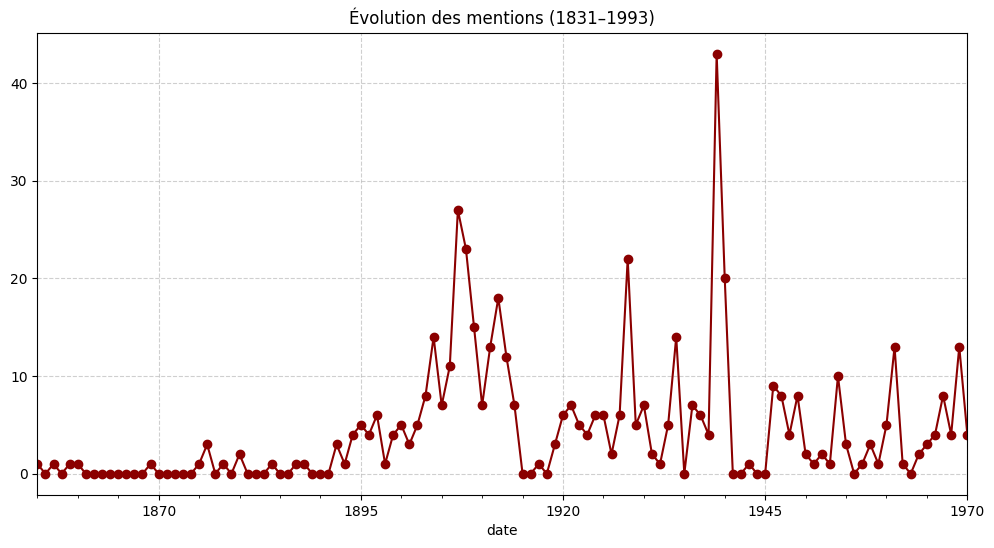

In [68]:
# le graphique
if 'date' in df.columns:  # Vérifie que la colonne existe
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date'])

    if not df.empty:
        plt.figure(figsize=(12, 6))
        df.set_index('date').resample('Y').size().plot(
            kind='line', marker='o', color='darkred',
            title="Évolution des mentions (1831–1993)"
        )
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.savefig("../../data/results/evolution.png", dpi=300)
        plt.show()
    else:
        print("⚠️ Pas assez de données pour le graphique")

## Extraire les mots clés d'un document avec Yake

### Configuration de l'extracteur yake

In [69]:
# Paramètres optimisés pour un corpus historique/journalistique
kw_extractor = yake.KeywordExtractor(
    lan="fr",          # Langue française
    n=3,               # Taille max des n-grammes (1=unigram, 2=bigram, 3=trigram)
    dedupLim=0.9,      # Seuil de déduplication (0.9 = très strict)
    dedupFunc='seqm',  # Méthode de déduplication (séquence matching)
    windowsSize=2,     # Taille de la fenêtre contextuelle
    top=100,           # Top 100 keywords par document
    features=None      # Utilise les paramètres par défaut
)

In [70]:
import os
os.listdir("../../data/txt_tp4")


['KB_JB838_1927-05-22_01-00007.txt',
 'KB_JB838_1940-12-17_01-00007.txt',
 'KB_JB837_1913-06-07_01-00001.txt',
 'KB_JB838_1960-12-02_01-00005.txt',
 'KB_JB427_1946-05-15_01-00006.txt',
 'KB_JB638_1869-01-07_01-00001.txt',
 'KB_JB567_1876-01-15_01-00001.txt',
 'KB_JB1051_1928-09-28_01-00004.txt',
 'KB_JB838_1955-09-29_01-00013.txt',
 'KB_JB729_1908-02-07_01-00001.txt',
 'KB_JB555_1939-10-16_01-00004.txt',
 'KB_JB1051_1966-05-04_01-00003.txt',
 'KB_JB572_1936-07-17_01-00010.txt',
 'KB_JB638_1929-11-15_01-00004.txt',
 'KB_JB567_1895-10-29_01-00003.txt',
 'KB_JB555_1888-04-27_01-00001.txt',
 'KB_JB421_1909-02-12_01-00001.txt',
 'KB_JB838_1969-05-30_01-00004.txt',
 'KB_JB427_1920-09-03_01-00003.txt',
 'KB_JB427_1924-08-23_01-00001.txt',
 'KB_JB773_1923-01-22_01-00001.txt',
 'KB_JB838_1940-10-01_01-00007.txt',
 'KB_JB838_1969-06-08_01-00004.txt',
 'KB_JB838_1934-02-01_01-00010.txt',
 'KB_JB555_1934-06-21_01-00003.txt',
 'KB_JB1051_1949-02-23_01-00006.txt',
 'KB_JB729_1937-10-08_01-00008.txt'

In [71]:
data_path = "../../data/txt_tp4"  # CORRECTION : Dossier, pas fichier unique

# Liste TOUS les fichiers .txt dans le dossier
files = sorted([f for f in os.listdir(data_path) if f.endswith('.txt')])
print(f"{len(files)} fichiers trouvés (ex: {files[:3]})")

512 fichiers trouvés (ex: ['KB_JB1051_1924-08-20_01-00004.txt', 'KB_JB1051_1928-05-11_01-00004.txt', 'KB_JB1051_1928-05-18_01-00004.txt'])


#### Fonction de nettoyage et filtrage

In [72]:
def nettoyer_texte(text):
    """Nettoie le texte brut (OCR errors, ponctuation, etc.)."""
    text = re.sub(r'[^\w\s\'\-]', ' ', text)  # Garde apostrophes et tirets
    text = re.sub(r'\s+', ' ', text).strip()   # Normalise les espaces
    return text

def filtrer_keywords(keywords):
    """Filtre les keywords pour garder ceux liés à l'amour atypique."""
    # Mots à exclure (bruit, lieux communs, etc.)
    mots_exclus = {
        "gay", "bruxelles", "bruxellois", "charleroi", "liège", "anvers", "paris", "londres",
        "allemand", "français", "belge", "européen", "trans", "transport", "rue", "place",
        "ville", "pays", "année", "temps", "jour", "heures", "hmu", "xii", "xix", "xxe",
        "—", "–", "…", "''", "``", "’", "‘", "“", "»", "«", "maison", "prix", "notaire"
    }

    # Mots cibles (liés à l'amour atypique)
    mots_cibles = {
        "amour", "mariage", "relation", "liaison", "couple", "union", "époux", "épouse",
        "fiancé", "fiancée", "passion", "désir", "affection", "sentiment", "homosexuel",
        "transgenre", "transsexuel", "changement", "genre", "interdit", "secret",
        "scandale", "moral", "immoral", "crime", "délit", "condamnation", "libre",
        "atypique", "différent", "autre", "déviant", "anormal", "normal", "affectif",
        "famille", "société", "église", "catholique", "loi", "légal", "illégal",
        "tolérance", "acceptation", "rejet", "stigmate", "péché", "vice", "honte",
        "caché", "clandestin", "concubinage", "cohabitation", "partenaire", "compagnon"
    }

    keywords_filtres = []
    for kw, score in keywords:
        kw_lower = kw.lower()
        # Exclut les mots non pertinents
        if any(exclu in kw_lower for exclu in mots_exclus):
            continue
        # Garde les mots cibles ou analysables
        if any(cible in kw_lower for cible in mots_cibles):
            keywords_filtres.append((kw, score))
            continue
        # Analyse avec spaCy pour exclure les entités nommées (noms de personnes/lieux)
        doc = nlp(kw)
        if any(ent.label_ in ("PER", "ORG", "LOC", "GPE") for ent in doc.ents):
            continue
        # Garde les autres mots (avec un score légèrement pénalisé)
        keywords_filtres.append((kw, score * 1.2))

    # Trie par score croissant (meilleurs keywords en premier)
    return sorted(keywords_filtres, key=lambda x: x[1])

# Extraction et affichage des résultats

In [73]:
results = []  # Stocke les résultats

# Boucle sur TOUS les fichiers (avec gestion des erreurs)
for f in tqdm(files, desc="Traitement des fichiers"):
    try:
        # 1. Lecture du fichier
        with open(os.path.join(data_path, f), 'r', encoding='utf-8') as file:
            text = file.read()

        # 2. Nettoyage
        text_nettoye = nettoyer_texte(text)

        # 3. Extraction des keywords
        keywords = kw_extractor.extract_keywords(text_nettoye)
        keywords_filtres = filtrer_keywords(keywords)

        # 4. Extraction des bigrammes
        bigrams = [kw for kw, _ in keywords_filtres if len(kw.split()) == 2]

        # 5. Extraction de la date (ex: "KB_JB838_1906-11-12_01-00004.txt" → "1906-11-12")
        date_match = re.search(r'(\d{4}-\d{2}-\d{2})', f)
        date = date_match.group(1) if date_match else None

        # 6. Stockage des résultats (SEULEMENT si des bigrammes pertinents)
        if bigrams and date:  # ← Vérifie que date n'est pas None
            results.append({
                "fichier": f,
                "date": date,  # ← Format AAAA-MM-JJ
                "bigrams": ", ".join(bigrams[:5]),  # Top 5 bigrammes
                "top_keywords": [{"keyword": kw, "score": score} for kw, score in keywords_filtres[:5]]
            })

    except Exception as e:
        print(f"⚠️ Erreur avec {f}: {str(e)}")
        continue  # Passe au fichier suivant

Traitement des fichiers:   9%|▉         | 47/512 [00:45<07:32,  1.03it/s]


KeyboardInterrupt: 

### Vérifie que le DataFrame n'est pas vide

In [ ]:
print(f"\n {len(results)} fichiers traités avec succès.")
if not results:
    print(" AUCUN RÉSULTAT ! Vérifie :")
    print("1. Le chemin des fichiers (`data_path`)")
    print("2. Que les fichiers sont bien en UTF-8")
    print("3. Que les mots-cibles (`mots_cibles`) sont pertinents")
else:
    print(" Exemple de résultat :")
    print(results[0])  # Affiche le premier résultat


 201 fichiers traités avec succès.
 Exemple de résultat :
{'fichier': 'KB_JB1051_1928-07-04_01-00004.txt', 'date': '1928-07-04', 'bigrams': 'local habituel', 'top_keywords': [{'keyword': 'local habituel RAYON', 'score': np.float64(4.1519372767977036e-06)}, {'keyword': "RAYON D'OUGREE Mercredi", 'score': np.float64(1.0621625844255404e-05)}, {'keyword': 'RAYON VII Vendredi', 'score': np.float64(1.4642192775712744e-05)}, {'keyword': 'Alexiens RAYON VII', 'score': np.float64(1.6261592881098063e-05)}, {'keyword': "LIEGE RAYON D'OUGREE", 'score': np.float64(1.903246491223762e-05)}]}


## Affichage et export des résultats

In [ ]:
print("\n--- Top 10 fichiers avec keywords pertinents ---")
for i, res in enumerate(results[:10], 1):
    print(f"\n{i}. {res['fichier']} (Date: {res['date']})")
    print("   Top bigrammes:", res['bigrams'])
    print("   Top keywords: ", [f"{kw} (score: {score:.4f})" for kw, score in res['top_keywords']])

# Export vers un DataFrame pandas (pour analyse ultérieure)
df = pd.DataFrame(results)
df.to_csv("../../data/results/keywords_amour_atypique.csv", index=False, encoding='utf-8')
print(f"\n Résultats exportés vers ../../data/results/keywords_amour_atypique.csv")


--- Top 10 fichiers avec keywords pertinents ---

1. KB_JB1051_1928-07-04_01-00004.txt (Date: 1928-07-04)
   Top bigrammes: local habituel


ValueError: Unknown format code 'f' for object of type 'str'

# Visuallisation

In [ ]:
print(df.head())  # Affiche les 5 premières lignes
print("\nColonnes disponibles :", df.columns.tolist())  # Liste les colonnes


Empty DataFrame
Columns: []
Index: []

Colonnes disponibles : []


In [49]:
import matplotlib.pyplot as plt

# 1. Vérifiez le nom exact de la colonne (ex: "date" ou "Date")
date_col = "date"  # Remplacez par le nom correct (ex: "Date" si majuscule)

# 2. Convertissez en datetime (en gérant les erreurs de format)
df[date_col] = pd.to_datetime(df[date_col], format='%Y-%m-%d', errors='coerce')

# 3. Supprimez les lignes avec des dates invalides (NaT)
df = df.dropna(subset=[date_col])

# 4. Tracé de l'évolution annuelle
plt.figure(figsize=(12, 6))
df.set_index(date_col).resample('Y').size().plot(
    kind='line',
    marker='o',
    linestyle='-',
    color='darkred',
    linewidth=2,
    title="Évolution des mentions de l'amour atypique (1831–1993)\nCorpus CAMille - Presse belge francophone",
    xlabel="Année",
    ylabel="Nombre d'articles"
)

# 5. Personnalisation du graphique
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# 6. Sauvegarde
plt.savefig("../../data/results/evolution_amour_atypique.png", dpi=300, bbox_inches='tight')
plt.show()



KeyError: 'date'

In [13]:
for f in sorted(files):
    text = open(os.path.join(data_path, f), 'r', encoding="utf-8").read()
    text = nettoyer_texte(text)
    keywords = kw_extractor.extract_keywords(text)
    keywords_filtres = filtrer_keywords(keywords)  # <-- Appel corrigé
    print(f"{f}: {keywords_filtres[:5]}")  # Affiche top 5 keywords filtrés

NameError: name 'files' is not defined

In [13]:
# Les dix premiers fichiers
files[:10]

['KB_JB838_1906-11-12_01-00004.txt',
 'KB_JB838_1970-06-13_01-00012.txt',
 'KB_JB838_1922-01-02_01-00007.txt',
 'KB_JB838_1952-02-29_01-00010.txt',
 'KB_JB838_1960-10-30_01-00007.txt',
 'KB_JB838_1966-08-30_01-00011.txt',
 'KB_JB838_1923-07-29_01-00003.txt',
 'KB_JB838_1893-11-28_01-00004.txt',
 'KB_JB838_1932-06-03_01-00011.txt',
 'KB_JB838_1961-12-30_01-00015.txt']

In [14]:
# Choisir un fichier
this_file = files[0]
this_file

'KB_JB838_1906-11-12_01-00004.txt'

In [15]:
# Récupérer le texte du fichier
text = open(os.path.join(data_path, this_file), 'r', encoding='utf-8').read()
text[:500]

"mi imnri r i «i i HMU ' î/tx-'l : Marché tenu hors villa, la 9. — U a été vaain Si téicj »M races indigènes de fr. 31<) à 5S'k 131 de. rasa îicHaKdui'te, do (r. 3S0 h 710. taureaux iallsènas,>ia ù\\ — à — ; 0II. hollandais, dufr. 0. — à 9.— la îdto- Vachei laitières: Bn vante 1Q. vendues 3\\ au prix la 410 à • «i h\\; génisses, Kl. '.9. i l. 2 i. id. da 370 i 6lütr. Marché a<u porcs. — Catégorie de lt ilashtya: ‘237 on vente; vendus 1 M.do ‘2 i.— à ;:, L —;i.l. des t'innlroV- I3ie;» vente, vendus 9"

In [16]:
# Extraire les mots clés de ce texte
keywords = kw_extractor.extract_keywords(text)
keywords

[('maison', np.float64(0.003077658230936859)),
 ('rue', np.float64(0.0030922660251063282)),
 ('Maison de rentier', np.float64(0.007451367309712659)),
 ('Bruxelles', np.float64(0.00835766510324691)),
 ('Maison de commerce', np.float64(0.008414175763105169)),
 ('contenant', np.float64(0.010937362215490024)),
 ('centiares', np.float64(0.012015936317427473)),
 ('Demain lundi', np.float64(0.012279832515679162)),
 ('notaire', np.float64(0.0123644825432676)),
 ('Vendue', np.float64(0.016154270207986227)),
 ('louée', np.float64(0.01619773308081534)),
 ('lundi', np.float64(0.0163930958621132)),
 ('prix', np.float64(0.018093579312602026)),
 ('rentier', np.float64(0.019894369366872527)),
 ('are', np.float64(0.020215747658765645)),
 ('commerce', np.float64(0.02922268570960821)),
 ('ruo', np.float64(0.032678799542358944)),
 ('lieu', np.float64(0.03290812001961487)),
 ('rue Haute', np.float64(0.0371357795514965)),
 ('demain lundi Carmen', np.float64(0.037591252103167105)),
 ('rue Gallait', np.float6

In [17]:
# Ne garder que les bigrammes
kept = []
for kw, score in keywords:
    words = kw.split()
    if len(words) == 2:
        kept.append(kw)
kept

['Demain lundi',
 'rue Haute',
 'rue Gallait',
 'maison mortuaire',
 'Notaire Van',
 'maisons qu’elle',
 'd’une maison',
 'rue Villa',
 'SUPERBE MAISON']

## Faire la même opération sur tous les documents

In [18]:
for f in sorted(files)[:10]:
    text = open(os.path.join(data_path, f), 'r', encoding="utf-8").read()
    keywords = kw_extractor.extract_keywords(text)
    kept = []
    for kw, score in keywords:
        words = kw.split()
        if len(words) == 2:
            kept.append(kw)
    print(f"{f} mentions these keywords: {', '.join(kept)}...")

KB_JB838_1887-12-22_01-00001.txt mentions these keywords: EXEMPLAIRES distribués, assassins politiques, distribués gratuitement, lomération bruxelloise, bruxelloise et.en, ræge quotidien, QUOTIDIEN GRATUIT, GRATUIT Température, facteur rural, Température Baromètre...
KB_JB838_1887-12-22_01-00002.txt mentions these keywords: Ligue nalio, rester fidèle, Van Ophem...
KB_JB838_1887-12-22_01-00003.txt mentions these keywords: prince Guillaume, Finet critique, Pierrot Macabre, HEURE Vienne...
KB_JB838_1887-12-22_01-00004.txt mentions these keywords: demande place, fiVS ÉPICERIES, ÉPICERIES t'Tu, lie Cologne, Fille val., place Madou, Bon Marché, rue Scailquin, rue Plantin, sci rue, bon certifie, rue lie, rue Bines, exposition Bruxelles, place sach, Bruxelles Centre, BRUXELLES Rideauœ...
KB_JB838_1887-12-22_01-00005.txt mentions these keywords: rue Plantin, OBJETS PERDUS, PERDUS gravure, LOUER DEMANDES, grande rue, rue Blaes, rue Hôtel, prix Bruxelles, rue Goflhrl, wôporler rue, rue St-Micliel